### Text Preprocessing

In [2]:
#Import all the necessary libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np


import collections
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import wordcloud

## for text processing
import re
import nltk

## for language detection
import langdetect 

## for sentiment
from textblob import TextBlob, Word, Blobber
from textblob.classifiers import NaiveBayesClassifier
from textblob.taggers import NLTKTagger

## for ner
import spacy

## for vectorizer
from sklearn import feature_extraction, manifold

## for word embedding
import gensim.downloader as gensim_api

## for topic modeling
import gensim



Bad key "text.kerning_factor" on line 4 in
/Users/HOME/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [399]:
#Read the data
ted_talks = pd.read_csv("/Users/HOME/Desktop/Springboard/TED-Talks/Data/ted_talks.csv",index_col = 0)
ted_talks.head()

,name,title,description,main_speaker,speaker_occupation,transcript,duration,film_date,published_date,languages,...,film_year,film_month,film_day,views_per_comment,num_ratings,funny,beautiful,inspiring,confusing,jaw_dropping
0,Ken Robinson: Do schools kill creativity?,Do schools kill creativity?,Sir Ken Robinson makes an entertaining and pro...,Ken Robinson,Author/educator,Good morning. How are you?(Laughter)It's been ...,19.400000,2006-02-24,2006-06-26,60,...,2006,February,Friday,0.000096,93850,19645,4573,24924,242,4439
1,Al Gore: Averting the climate crisis,Averting the climate crisis,With the same humor and humanity he exuded in ...,Al Gore,Climate advocate,"Thank you so much, Chris. And it's truly a gre...",16.283333,2006-02-24,2006-06-26,43,...,2006,February,Friday,0.000083,2936,544,58,413,62,116
2,David Pogue: Simplicity sells,Simplicity sells,New York Times columnist David Pogue takes aim...,David Pogue,Technology columnist,"(Music: ""The Sound of Silence,"" Simon & Garfun...",21.433333,2006-02-23,2006-06-26,26,...,2006,February,Thursday,0.000076,2824,964,60,230,27,54
3,Majora Carter: Greening the ghetto,Greening the ghetto,"In an emotionally charged talk, MacArthur-winn...",Majora Carter,Activist for environmental justice,If you're here today — and I'm very happy that...,18.600000,2006-02-25,2006-06-26,35,...,2006,February,Saturday,0.000118,3728,59,291,1070,32,230
4,Hans Rosling: The best stats you've ever seen,The best stats you've ever seen,You've never seen data presented like this. Wi...,Hans Rosling,Global health expert; data visionary,"About 10 years ago, I took on the task to teac...",19.833333,2006-02-21,2006-06-27,48,...,2006,February,Tuesday,0.000049,25620,1390,942,2893,72,3736


### Language Detection

First of all, I want to make sure that I’m dealing with the same language and with the langdetect package this is really easy.

In [400]:
ted_talks['lang'] = (ted_talks['transcript'].fillna("")).apply(lambda x: langdetect.detect(x) if x.strip() != "" else "")

In [5]:
ted_talks['lang'].value_counts()

en    2463
        86
fr       1
Name: lang, dtype: int64

There are 2463 transcripts in english,1 trascript in french and rest of them are NULL transcripts.

In [6]:
ted_talks[ted_talks['lang'] == 'fr']

,name,title,description,main_speaker,speaker_occupation,transcript,duration,film_date,published_date,languages,...,film_month,film_day,views_per_comment,num_ratings,funny,beautiful,inspiring,confusing,jaw_dropping,lang
98,"Rachelle Garniez: ""La Vie en Rose""","""La Vie en Rose""",Featuring the vocals and mischievous bell-play...,Rachelle Garniez,Musician,Thomas Dolby: For pure pleasure please welcome...,3.35,2004-02-01,2007-04-15,33,...,February,Sunday,0.000088,521,58,224,40,8,12,fr


In [7]:
ted_talks['transcript'].iloc[98]

"Thomas Dolby: For pure pleasure please welcome the lovely, the delectable, and the bilingual Rachelle Garniez.(Applause)(Bells)(Trumpet)Rachelle Garniez: ♫ Quand il me prend dans ses bras ♫♫ Il me parle tout bas, ♫♫ Je vois la vie en rose. ♫♫ Il me dit des mots d'amour, ♫♫ Des mots de tous les jours, ♫♫ Et ca me fait quelque chose. ♫♫ Il est entre dans mon coeur ♫♫ Une part de bonheur ♫♫ Dont je connais la cause. ♫♫ C'est lui pour moi. Moi pour lui ♫♫ Dans la vie, ♫♫ Il me l'a dit, l'a jure [pour] la vie. ♫♫ Et des que je l'apercois ♫♫ Alors je sens en moi ♫♫ Mon coeur qui bat ♫(Applause)"

From the above transcript ,we can confirm that its in french.We are going to delete that to deal with the english language transcripts only.We will keep the NULL transcripts for further analysis,then later we will drop them too.

In [7]:
ted_talks = ted_talks[~ (ted_talks['lang'] == 'fr')]

### Text Preprocessing


Data preprocessing is the phase of preparing raw data to make it suitable for a machine learning model. For NLP, that includes text cleaning, stopwords removal, stemming and lemmatization.

Text cleaning steps vary according to the type of data and the required task. Generally, the string is converted to lowercase and punctuation is removed before text gets tokenized. Tokenization is the process of splitting a string into a list of strings (or “tokens”).

Text normalization includes:

- converting all letters to lower or upper case
- converting numbers into words or removing numbers
- removing punctuations, accent marks and other diacritics
- removing white spaces
- expanding abbreviations
- removing stop words, sparse terms, and particular words
- text canonicalization

In [192]:
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
def text_preprocess(text):
    text = re.sub(r"\((.*?)\)", r" ", text).lower()
    nlp = en_core_web_sm.load()
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    a_lemmas = [lemma for lemma in lemmas if lemma.isalpha() and lemma not in STOP_WORDS]
    return ' '.join(a_lemmas)

In [193]:
ted_talks['clean_transc'] = (ted_talks['transcript'].fillna("")).apply(text_preprocess)

In [194]:
ted_talks.to_csv("/Users/HOME/Desktop/Springboard/TED-Talks/Data/clean_transcript_1.csv")

### Length Analysis

It’s important to have a look at the length of the text because it’s an easy calculation that can give a lot of insights. Maybe, for instance, we are lucky enough to discover that one category is systematically longer than another and the length would simply be the only feature needed to build the model.

In [8]:
ted_talks['word_count'] = (ted_talks['transcript'].fillna("")).apply(lambda x: len(str(x).split(" ")))
ted_talks['char_count'] = (ted_talks['transcript'].fillna("")).apply(lambda x: sum(len(word) for word in str(x).split(" ")))
ted_talks['sentence_count'] = (ted_talks['transcript'].fillna("")).apply(lambda x: len(str(x).split(".")))
ted_talks['avg_word_length'] = ted_talks['char_count'] / ted_talks['word_count']
ted_talks['avg_sentence_length'] = ted_talks['word_count'] / ted_talks['sentence_count']
ted_talks.head()


,name,title,description,main_speaker,speaker_occupation,transcript,duration,film_date,published_date,languages,...,beautiful,inspiring,confusing,jaw_dropping,lang,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
0,Ken Robinson: Do schools kill creativity?,Do schools kill creativity?,Sir Ken Robinson makes an entertaining and pro...,Ken Robinson,Author/educator,Good morning. How are you?(Laughter)It's been ...,19.400000,2006-02-24,2006-06-26,60,...,4573,24924,242,4439,en,3066,14344,225,4.678408,13.626667
1,Al Gore: Averting the climate crisis,Averting the climate crisis,With the same humor and humanity he exuded in ...,Al Gore,Climate advocate,"Thank you so much, Chris. And it's truly a gre...",16.283333,2006-02-24,2006-06-26,43,...,58,413,62,116,en,2089,9726,141,4.655816,14.815603
2,David Pogue: Simplicity sells,Simplicity sells,New York Times columnist David Pogue takes aim...,David Pogue,Technology columnist,"(Music: ""The Sound of Silence,"" Simon & Garfun...",21.433333,2006-02-23,2006-06-26,26,...,60,230,27,54,en,3253,15057,256,4.628650,12.707031
3,Majora Carter: Greening the ghetto,Greening the ghetto,"In an emotionally charged talk, MacArthur-winn...",Majora Carter,Activist for environmental justice,If you're here today — and I'm very happy that...,18.600000,2006-02-25,2006-06-26,35,...,291,1070,32,230,en,3015,15235,181,5.053068,16.657459
4,Hans Rosling: The best stats you've ever seen,The best stats you've ever seen,You've never seen data presented like this. Wi...,Hans Rosling,Global health expert; data visionary,"About 10 years ago, I took on the task to teac...",19.833333,2006-02-21,2006-06-27,48,...,942,2893,72,3736,en,3121,14245,236,4.564242,13.224576


### Sentiment Analysis

Sentiment analysis is the representation of subjective emotions of text data through numbers or classes. 
**Textblob**, built on top of NLTK, is one of the most popular, it can assign polarity to words and estimate the sentiment of the whole text as an average.The polarity score is a float within the range [-1.0, 1.0]. 

Now we are going to add sentiment feature with Textblob.

In [9]:
#TextBlob
ted_talks['sentiment'] = (ted_talks['transcript'].fillna('')).apply(lambda x: TextBlob(x).sentiment.polarity)

### Extracting rating category from Ratings

Here we are going to convert 

- ['Longwinded', 'Obnoxious', 'Unconvincing', 'Confusing','OK'] as Negative rating.



In [ ]:
import ast
ted_talks['ratings'] = ted_talks['ratings'].apply(ast.literal_eval)

In [233]:
'''
pos_word = ['Beautiful' , 'Courageous', 'Fascinating', 'Funny', 'Informative', 'Ingenious', 'Inspiring', 
            'Jaw-dropping', 'Persuasive']
neg_word = ['Longwinded', 'Obnoxious', 'Unconvincing', 'Confusing']
neutral = ['OK']

sentiment = ['positive', 'negative', 'neutral']
sent_lab = []

for record in ted_talks['ratings']:
    neg_count = 0
    pos_count = 0
    neutral_count = 0
    for rating in record:
        if rating['name'] in neg_word:
            neg_count+= rating['count']
        elif rating['name'] in neutral:
            neutral_count+= rating['count']
        else:
            pos_count+= rating['count']

    score = [pos_count,neg_count,neutral_count]
    sent_lab.append(sentiment[score.index(np.max(score))])
    
    #ted_talks['sent'] = sentiment[score.index(np.max(score))]
    #print("positive - {}, negative - {}, neutral - {}, label - {}".format(pos_count,neg_count,neutral_count,sentiment[np.argmax(score)])) 
ted_talks['sentiment_category'] = np.array(sent_lab)

In [1434]:
#assigning the most rated category as the final rating
import operator
d = {}
comment = []

for record in ted_talks['ratings']:
    for rating in record:
        d[rating['name']] = rating['count']
    comment.append(max(d.items(), key=operator.itemgetter(1))[0])
    
ted_talks['rating'] = np.array(comment) 
        

In [ ]:
columns = ['Unconvincing', 'Longwinded', 'Obnoxious', 'Confusing']
ted_talks['rating'] = ted_talks['rating'].replace(columns, 'negative')

In [372]:
ted_talks['rating'].value_counts()

Inspiring       848
Informative     712
Fascinating     250
Funny           158
Beautiful       135
Ingenious       101
Courageous       82
Persuasive       79
Jaw-dropping     48
negative         36
OK                6
Name: rating, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

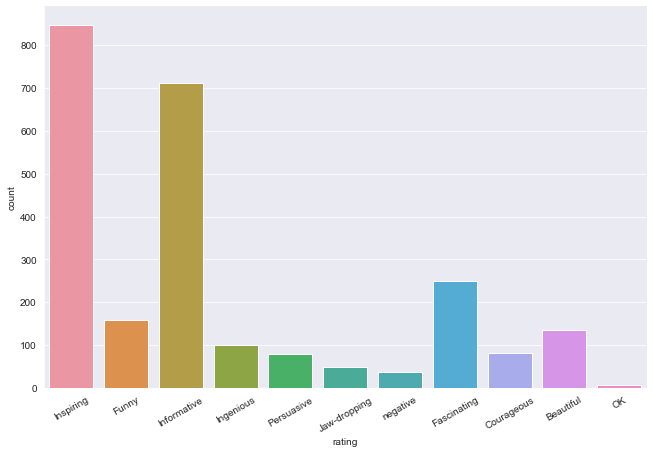

In [378]:
#Visualize the ratings category distrubution
sns.catplot(x = 'rating', kind = 'count', data = ted_talks,height=6, aspect=1.5)
plt.xticks(rotation = 30)

Summary findings:

- Most of the TED Talks got Inspiring rating and very few got negative rating.
- And the above plot concludes that the dataset is very imbalanced.

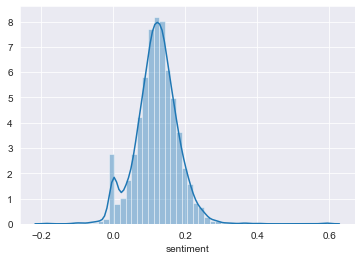

In [266]:
#Visualizing the sentiment distribution on TED talks
sns.distplot(ted_talks['sentiment'])

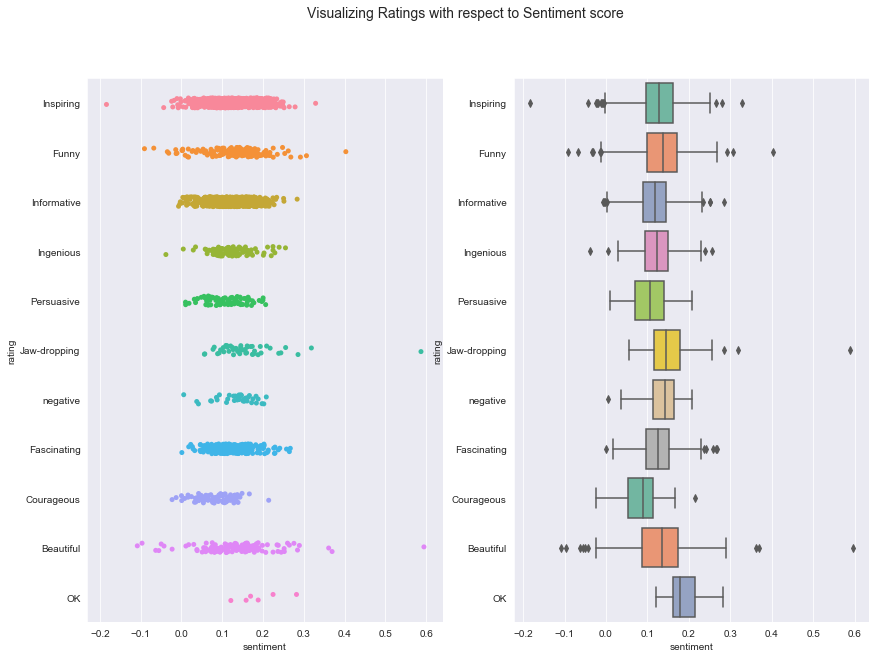

In [389]:
#Visualizing ratings with respect to sentiment score
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))
sp = sns.stripplot(x = 'sentiment', y='rating', data = ted_talks, ax=ax1)
                   
bp = sns.boxplot(x = 'sentiment', y='rating', data = ted_talks, ax=ax2, palette="Set2")
                 
t = f.suptitle('Visualizing Ratings with respect to Sentiment score', fontsize=14)

Text(0.5, 1, 'Top 10 most popular themes by sentiment category')

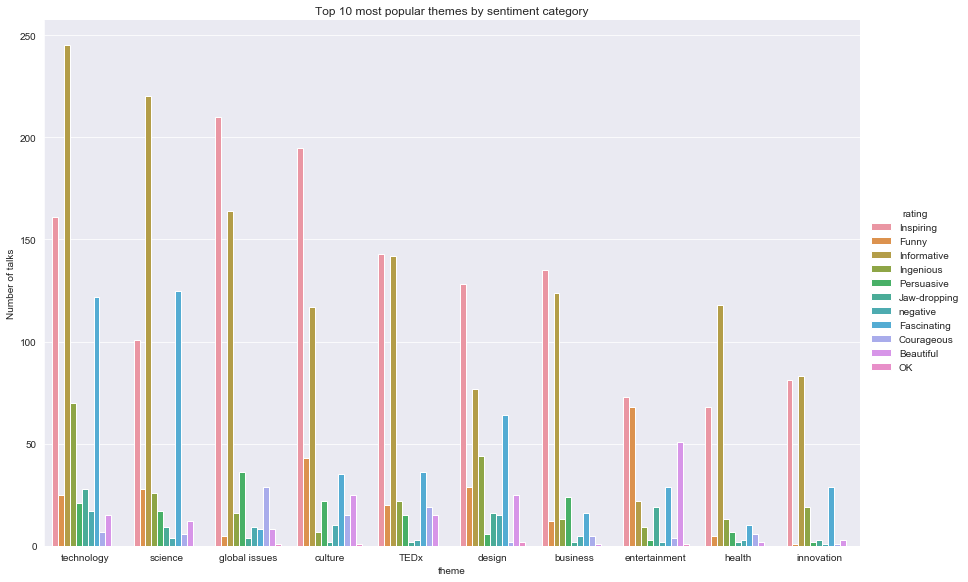

In [394]:
#Visualizing the Top 10 TED Talks Themes by rating
import ast
df = ted_talks.copy()
df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x))
s = df.apply(lambda x: pd.Series(x['tags']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'theme'
theme_df = df.drop('tags', axis=1).join(s)
theme_df.head()

#sns.factorplot(x="news_category", hue="sentiment_category", data=ted_talks, kind="count"
sns.catplot(x = 'theme', kind = 'count', data = theme_df, hue="rating",height = 8,aspect = 1.5,
           order = theme_df.theme.value_counts().iloc[:10].index)
plt.ylabel("Number of talks")
plt.title("Top 10 most popular themes by sentiment category")


Summary findings:

- **technology,Science,health,innovation** themes of TED Talks got Informative as the primary ratings.
- And all the rest of the themes got Inspiring as the primary ratings.


### Feature Engineering

First we will extract features from the existing features of TED Talks. And then we will extract features from transcript.

In [336]:
ted_talks['speaker_occupation'] = ted_talks['speaker_occupation'].apply(lambda x: re.split((r'\band\b|,|;|/|-'),x))

In [385]:
ted_talks['main_speaker'] = ted_talks['main_speaker'].apply(lambda x: re.split((r'\band\b|\+|,'),x))

In [417]:
def get_Ingenious_ratings(list_of_dicts):
    for d in list_of_dicts:
        if d['name'] == 'Ingenious':
            return d['count']
            
def get_Courageous_ratings(list_of_dicts):
    for d in list_of_dicts:
        if d['name'] == 'Courageous':
            return d['count']
           
def get_Longwinded_ratings(list_of_dicts):
    for d in list_of_dicts:
        if d['name'] == 'Longwinded':
            return d['count']
        
def get_Informative_ratings(list_of_dicts):
    for d in list_of_dicts:
        if d['name'] == 'Informative':
            return d['count']
        
def get_Fascinating_ratings(list_of_dicts):
    for d in list_of_dicts:
        if d['name'] == 'Fascinating':
            return d['count']
        
def get_Unconvincing_ratings(list_of_dicts):
    for d in list_of_dicts:
        if d['name'] == 'Unconvincing':
            return d['count']
        
def get_Persuasive_ratings(list_of_dicts):
    for d in list_of_dicts:        
        if d['name'] == 'Persuasive':
            return d['count']
        
def get_OK_ratings(list_of_dicts):
    for d in list_of_dicts:
        if d['name'] == 'OK':
            return d['count']
        
def get_Obnoxious_ratings(list_of_dicts):
    for d in list_of_dicts:
        if d['name'] == 'Obnoxious':
            return d['count']

ted_talks['ingenious'] = ted_talks['ratings'].apply(get_Ingenious_ratings)
ted_talks['courageous'] = ted_talks['ratings'].apply(get_Courageous_ratings)
ted_talks['longwinded'] = ted_talks['ratings'].apply(get_Longwinded_ratings)
ted_talks['informative'] = ted_talks['ratings'].apply(get_Informative_ratings)
ted_talks['fascinating'] = ted_talks['ratings'].apply(get_Fascinating_ratings)
ted_talks['unconvincing'] = ted_talks['ratings'].apply(get_Unconvincing_ratings)
ted_talks['persuasive'] = ted_talks['ratings'].apply(get_Persuasive_ratings)
ted_talks['ok'] = ted_talks['ratings'].apply(get_OK_ratings)
ted_talks['obnoxious'] = ted_talks['ratings'].apply(get_Obnoxious_ratings)

In [1545]:
ted_talks.to_csv("/Users/HOME/Desktop/Springboard/TED-Talks/Data/preprocessed_ted.csv")

### Encoding categorical variables

In [421]:
#load the final topic modeling dataset
ted_talks = pd.read_csv("/Users/HOME/Desktop/Springboard/TED-Talks/Models/ted_modeling.csv")

In [422]:
#selecting the features for final dataset
ted_sentiment = ted_talks[['main_speaker', 'speaker_occupation','duration','languages',
       'num_speaker','event', 'comments', 'views', 'tags','film_year','film_month', 'film_day',
       'views_per_comment', 'num_ratings', 'lang', 'word_count', 'char_count',
       'sentence_count', 'avg_word_length', 'avg_sentence_length', 'clean_transc',
                           'rating','sentiment','topic', 'topic_tag']]

In [423]:
import ast
ted_sentiment['tags'] = ted_sentiment['tags'].apply(lambda x: ast.literal_eval(x))

In [424]:
ted_sentiment = ted_sentiment[~ (ted_sentiment['clean_transc'] == '')]

In [425]:
ted_sentiment.select_dtypes(include=['object']).columns

Index(['main_speaker', 'speaker_occupation', 'event', 'tags', 'film_month',
       'film_day', 'lang', 'clean_transc', 'rating', 'topic_tag'],
      dtype='object')

In [426]:
ted_sentiment['main_speaker'] = ted_sentiment['main_speaker'].apply(lambda x: ast.literal_eval(x))
ted_sentiment['speaker_occupation'] = ted_sentiment['speaker_occupation'].apply(lambda x: ast.literal_eval(x))


In [427]:
ted_sentiment['main_speaker'] = ted_sentiment['main_speaker'].apply(lambda x: [i.strip(' ').lower() for i in x])
ted_sentiment['speaker_occupation'] = ted_sentiment['speaker_occupation'].apply(lambda x: [i.strip(' ').lower() for i in x])

In [428]:
months = {'January' : 1,
         'February' : 2,
         'March' : 3,
         'April' : 4,
         'May' : 5,
         'June' : 6,
         'July' : 7,
         'August' : 8,
         'September' : 9,
         'October' : 10,
         'November' : 11,
         'December' : 12}
ted_sentiment = ted_sentiment.replace({'film_month': months})

In [429]:
days = {'Monday' : 1,
       'Tuesday' : 2,
       'Wednesday' : 3,
       'Thursday' : 4,
       'Friday' : 5,
       'Saturday' : 6,
       'Sunday' : 7}
ted_sentiment = ted_sentiment.replace({'film_day': days})

In [430]:
#Binary Encoding for event feature
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=['event'])
ted_sentiment = encoder.fit_transform(ted_sentiment)


In [431]:
#get_dummies for lang feature
ted_sentiment = pd.concat([ted_sentiment.drop('lang', axis=1), pd.get_dummies(ted_sentiment['lang'])], axis=1)

In [432]:
#MultiLabelBinarizer for tags
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
tag = pd.DataFrame(mlb.fit_transform(ted_sentiment['tags']),columns=mlb.classes_)
ted_sentiment = pd.concat([ted_sentiment.drop('tags', axis=1), tag.set_index(ted_sentiment.index)], axis=1)

In [433]:
#MultiLabelBinarizer for main_speaker
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
speaker = pd.DataFrame(mlb.fit_transform(ted_sentiment['main_speaker']),columns=mlb.classes_)
ted_sentiment = pd.concat([ted_sentiment.drop('main_speaker', axis=1), speaker.set_index(ted_sentiment.index)], axis=1)

In [434]:
#MultiLabelBinarizer for speaker_occupation
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
occupation = pd.DataFrame(mlb.fit_transform(ted_sentiment['speaker_occupation']),columns=mlb.classes_)
ted_sentiment = pd.concat([ted_sentiment.drop('speaker_occupation', axis=1),occupation.set_index(ted_sentiment.index)], axis=1)

In [435]:
ted_sentiment.shape

(2455, 3846)

In [436]:
ted_sentiment['topic_tag'] = ted_sentiment['topic_tag'].apply(lambda x: ast.literal_eval(x))
ted_sentiment['topic_tag'] = ted_sentiment['topic_tag'].apply(lambda x: [i.strip(' ').lower() for i in x])

In [437]:
#MultiLabelBinarizer for speaker_occupation
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
topics_tag = pd.DataFrame(mlb.fit_transform(ted_sentiment['topic_tag']),columns=mlb.classes_)
ted_sentiment = pd.concat([ted_sentiment.drop('topic_tag', axis=1),topics_tag.set_index(ted_sentiment.index)], axis=1)


In [450]:

columns = ['Unconvincing', 'Longwinded', 'Obnoxious', 'Confusing']
ted_sentiment['rating'] = ted_sentiment['rating'].replace(columns, 'negative')

In [452]:
#pickle the model
with open("/Users/HOME/Desktop/Springboard/TED-Talks/Models/" + 'ted_encoded.pkl', 'wb') as picklefile:
    pickle.dump(ted_sentiment, picklefile)


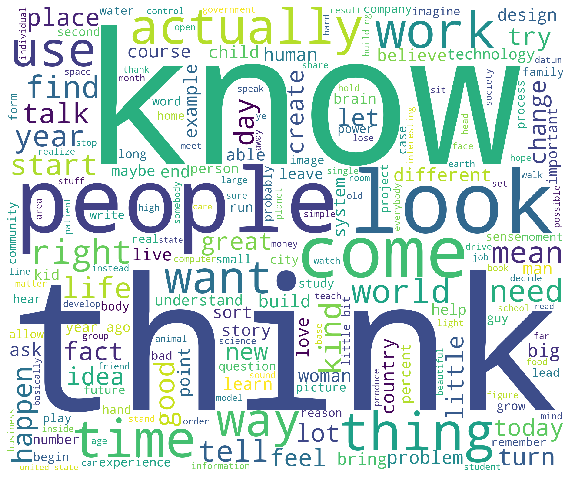

In [1048]:
#Cleaned transcript wordcloud
corpus = ' '.join(ted_talks['clean_transc'])
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white',width=2400,height=2000).generate(corpus)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [1533]:
'''
def get_pranathesis_words(text):
    d = defaultdict(int)
    s = re.findall(r'\(.*?\)',text)
    for word in s:
        d[word.strip('( | )')]+= 1
    return d
